# Let's explore how EI converges as samples increases

In [1]:
import os
from pathlib import Path
from itertools import islice
import gzip
import pickle
from collections import defaultdict

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

from ei import topology_of, EI_of_layer

In [67]:
# Pretty colormaps
def greyscaleMap(collection, item):
    size = len(collection)
    pos = collection.index(item)
    colormap = matplotlib.cm.get_cmap("binary")
    return colormap((((0.6 / size * pos) + 0.1)))
                    
def rainbowMap(collection, item):
    size = len(collection)
    pos = collection.index(item)
    colormap = matplotlib.cm.get_cmap("rainbow")
    return colormap(1.0 * pos / size)

def magmaMap(collection, item):
    size = len(collection)
    pos = collection.index(item)
    colormap = matplotlib.cm.get_cmap("magma")
    return colormap(0.7 * pos / size + 0.2)

def blueMap(collection, item):
    size = len(collection)
    pos = collection.index(item)
    colormap = matplotlib.cm.get_cmap("Blues")
    return colormap(0.85 * pos / size + 0.15) # avoid using the lightest blue color -- it's not visible

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# dtype = torch.cuda.float if torch.cuda.is_available() else torch.float
dtype = torch.float32
torch.set_default_dtype(dtype)
print(f"Using device: {device}")

Using device: cuda


## Example graph:

In [21]:
initializers = {
    'kaiming': None, # (default)
    'xavier_uniform': nn.init.xavier_uniform_,
    'xavier_normal': nn.init.xavier_normal_,
    'paper': nn.init.uniform_
}

In [29]:
def weight_initializer(name):
    def init_weights(m):
        if name == 'kaiming':
            return
        if name == 'paper':
            if isinstance(m, nn.Linear):
                boundary = 1 / np.sqrt(m.in_features)
                nn.init.uniform_(m.weight, a=-boundary, b=boundary)
        elif isinstance(m, nn.Linear):
            initializers[name](m.weight)
    return init_weights

In [46]:
widths = [8, 16, 32, 64, 128, 256, 512]  # 64, 128, 256, 512, 1024]

In [47]:
sample_sizes = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 
                15000, 20000, 30000, 40000, 50000, 75000, 100000, 200000,
                300000, 500000, 800000]
eis = defaultdict(list)

for width in widths:
    network = nn.Linear(width, width, bias=False).to(device)
    top = topology_of(network, input=torch.zeros((1, width)).to(device))
    network.apply(weight_initializer('paper'))
    for size in sample_sizes:
        EI = EI_of_layer(network, top, 
                         samples=size, 
                         batch_size=300, 
                         bins=64,
                         activation=nn.Sigmoid(),
                         in_range=(0, 1), 
                         out_range=(0, 1),
                         device=device)
        eis[width].append(EI)
    print("done with {}".format(width))

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
15000
20000
30000
40000
50000
75000
100000
200000
300000
500000
800000
done with 8
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
15000
20000
30000
40000
50000
75000
100000
200000
300000
500000
800000
done with 16
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
15000
20000
30000
40000
50000
75000
100000
200000
300000
500000
800000
done with 32
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
15000
20000
30000
40000
50000
75000
100000
200000
300000
500000
800000
done with 64
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
15000
20000
30000
40000
50000
75000
100000
200000
300000
500000
781250
18750
done with 128
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
15000
20000
30000
40000
50000
75000
100000
200000
300000
390625
109375
390625
390625
18750
done with 256
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
15000
20000
30000
40000
50000
75000
100000
195312
4688
195312
104688
195312
195312
109376
195312
195312
195312
1

In [74]:
with open("data/convergence.pkl", "wb") as f:
    pickle.dump(eis, f)

In [77]:
with open("data/convergence.pkl", "rb") as f:
    eis = pickle.load(f)

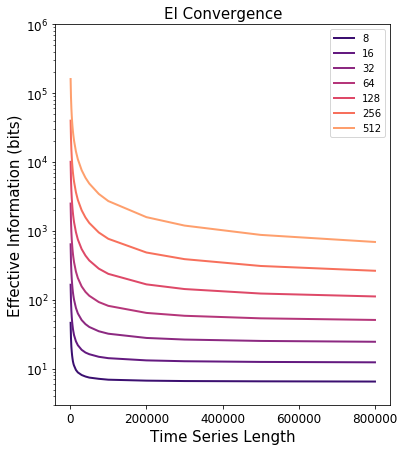

In [81]:
fig = plt.figure(figsize=(6, 7))
ax = fig.gca()
#fig, ax = plt.subplots(1,1)
#plt.figsize()
for width in widths:
    plt.plot(sample_sizes, eis[width], label=str(width), color=magmaMap(widths, width), linewidth=2)
    
#matplotlib.pyplot.plot((0.0,seriesMax / seriesDelta),(0.0,0.0),'lightgray')
# fig.legend(loc=(0.69,0.58),prop={'size':10})

#plt.autoscale(False)
# ax.plot((30,30),(-20.0,405),'black')

ax.set_title("EI Convergence", fontsize=15)
ax.set_xlabel('Time Series Length', fontsize=15)
ax.set_ylabel('Effective Information (bits)', fontsize=15)
plt.yscale('log')
plt.ylim(3, 1000000)
# plt.xlim(0, 650000)

# ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(200000))
ax.tick_params(axis='both', which='major',labelsize=12)
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(200000))

# plt.draw()
# limit = ax.get_ylim()
plt.autoscale(False)
# ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(15))
# ax.xaxis.set_ticklabels(['','0','15,000','30,000','45,000','60,000', '100,000'])

plt.legend(loc='upper right') #, title="width")

plt.savefig("figures/convergence/convergence_standard_big_tall", dpi=300)

## I notice that even after 800000, even for small layers, EI hasn't converged as well as I'd have hoped. Let's inspect this:

In [87]:
width = 30
network = nn.Linear(width, width, bias=False).to(device)
network.apply(weight_initializer('paper'))
top = topology_of(network, input=torch.zeros((1, width)).to(device))

eis_long = []
lengths = [50000, 100000, 200000, 400000, 800000, 1600000, 3200000, 6400000, 12800000, 25600000, 51200000]
for length in lengths:
    EI = EI_of_layer(network, top, 
                     samples=length, 
                     batch_size=100, 
                     bins=64,
                     activation=nn.Sigmoid(),
                     in_range=(0, 1), 
                     out_range=(0, 1),
                     device=device)
    eis_long.append(EI)

50000
100000
200000
400000
800000
1600000
3200000
3333333
3066667
3333333
3333333
3333333
2800001
3333333
3333333
3333333
3333333
3333333
3333333
3333333
2266669
3333333
3333333
3333333
3333333
3333333
3333333
3333333
3333333
3333333
3333333
3333333
3333333
3333333
3333333
3333333
1200005


In [88]:
for ei in eis_long:
    print(ei)

36.82578152485245
29.676967790300267
25.99123895774333
24.069946885389232
23.099360736186807
22.602075322213945
22.328272186164973
22.189842812347383
22.12353420795529
22.085022482801477
22.06853443698957


## Let's now compare this with the automatic stopping function:

In [89]:
EI = EI_of_layer(network, top,
                threshold=0.05,
                batch_size=100,
                bins=64,
                activation=nn.Sigmoid(),
                in_range=(0, 1),
                out_range=(0, 1),
                device=device)
print(EI)

10000
10000: 87.78156383538193
10000
20000: 56.34646886503279
20000
40000: 40.005927283676165
40000
80000: 31.389300475836617
80000
160000: 26.88100360249247
160000
320000: 24.562069557615953
320000
640000: 23.34418344470418
640000
1280000: 22.714698926383985
1280000
2560000: 22.391248574027475
22.391248574027475


## Let's now instead of plotting the EI vs samples for different layer widths, let's fix the layer width and instead plot for different number of bins.

In [91]:
sample_sizes = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 
                15000, 20000, 30000, 40000, 50000, 75000, 100000, 200000,
                300000, 500000, 800000]
bin_sizes = [8, 16, 32, 64, 128]

eis = defaultdict(list)

width = 30
network = nn.Linear(width, width, bias=False).to(device)
top = topology_of(network, input=torch.zeros((1, width)).to(device))
network.apply(weight_initializer('paper'))

for bins in bin_sizes:
    for size in sample_sizes:
        EI = EI_of_layer(network, top, 
                         samples=size, 
                         batch_size=100, 
                         bins=bins,
                         activation=nn.Sigmoid(),
                         in_range=(0, 1), 
                         out_range=(0, 1),
                         device=device)
        eis[bins].append(EI)
    print("done with {}".format(bins))

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
15000
20000
30000
40000
50000
75000
100000
200000
300000
500000
800000
done with 8
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
15000
20000
30000
40000
50000
75000
100000
200000
300000
500000
800000
done with 16
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
15000
20000
30000
40000
50000
75000
100000
200000
300000
500000
800000
done with 32
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
15000
20000
30000
40000
50000
75000
100000
200000
300000
500000
800000
done with 64
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
15000
20000
30000
40000
50000
75000
100000
200000
300000
500000
800000
done with 128


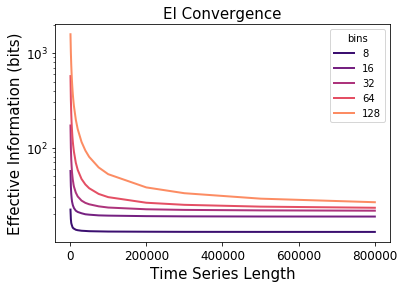

In [103]:
fig = plt.figure(figsize=(6, 4))
ax = fig.gca()
#fig, ax = plt.subplots(1,1)
#plt.figsize()
for bins in bin_sizes:
    plt.plot(sample_sizes, eis[bins], label=str(bins), color=magmaMap(bin_sizes, bins), linewidth=2)
    
#matplotlib.pyplot.plot((0.0,seriesMax / seriesDelta),(0.0,0.0),'lightgray')
# fig.legend(loc=(0.69,0.58),prop={'size':10})

#plt.autoscale(False)
# ax.plot((30,30),(-20.0,405),'black')

ax.set_title("EI Convergence", fontsize=15)
ax.set_xlabel('Time Series Length', fontsize=15)
ax.set_ylabel('Effective Information (bits)', fontsize=15)
plt.yscale('log')
# plt.ylim(8, 500)
#plt.xlim(0, 650000)

# ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(200000))
ax.tick_params(axis='both', which='major',labelsize=12)
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(200000))

# plt.draw()
# limit = ax.get_ylim()
# plt.autoscale(False)
# ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(15))
# ax.xaxis.set_ticklabels(['','0','15,000','30,000','45,000','60,000', '100,000'])

plt.legend(loc='upper right', title="bins")

plt.savefig("figures/convergence/convergence_standard_varying_bins_30_wide", dpi=300)